# **Evaluación de métodos de generación de numeros aleatorios**.
**Autores:** Samuel Jacobo Garavito Segura, Fabian Andres Ruiz Tortello y Heldert Villegas Jaramillo.

El siguiente Notebook es un complemento del articulo: *Evaluación de métodos de generación de números aleatorios*, para mas informacion remitirse a esta referencia. En el encontrará las implementaciones de los Generadores de Numeros pseudo-aleatorios ($GNPA$) Messene Twister, Xorshift e Itamaraca junto a los test de aletoriedad de *Kolmogorov, $\chi^2$ y *Binary Rank* mediante los cuales seran evaluados. 


## Librerias Necesarias

Se hizo uso de las siguientes librerias para el correcto desarrollo de las implementaciones. 

In [ ]:
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy import stats
import numpy as np
import random
import math
import time

# Determinacion de proporciones:

La siguiente funcion permitira posteriormente hacer un estudio de cada una de las simulaciones desde una perspectiva frecuentista. 


In [ ]:
def prop(arr, criteria):
  occurrences = np.greater_equal(arr, criteria ) 
  return occurrences.sum()/len(arr), np.abs(occurrences.sum() - len(arr))/len(arr)

Este código determinará la proporción de los $p-valores$  para aceptacion o rechazo de una cadena de números aleatorios. 



## Generador $GNPA$ Merssene Twister

A continuación encontrará la implementación del Generador *Merssene Twister* tomado de https://github.com/james727/MTP.

In [ ]:
class Random():
  
    def __init__(self, c_seed=0):

        # MT19937
        (self.w, self.n, self.m, self.r) = (32, 624, 397, 31)
        self.a = 0x9908B0DF
        (self.u, self.d) = (11, 0xFFFFFFFF)
        (self.s, self.b) = (7, 0x9D2C5680)
        (self.t, self.c) = (15, 0xEFC60000)
        self.l = 18
        self.f = 1812433253
        # make a arry to store the state of the generator
        self.MT = [0 for i in range(self.n)]
        self.index = self.n+1
        self.lower_mask = 0x7FFFFFFF
        self.upper_mask = 0x80000000
        # inital the seed
        self.c_seed = c_seed
        self.seed(c_seed)

    def seed(self, num):

        """initialize the generator from a seed"""

        self.MT[0] = num
        self.index = self.n
        for i in range(1, self.n):
            temp = self.f * (self.MT[i-1] ^ (self.MT[i-1] >> (self.w-2))) + i
            self.MT[i] = temp & 0xffffffff

    def twist(self):

        """ Generate the next n values from the series x_i"""

        for i in range(0, self.n):
            x = (self.MT[i] & self.upper_mask) + \
                (self.MT[(i+1) % self.n] & self.lower_mask)
            xA = x >> 1
            if (x % 2) != 0:
                xA = xA ^ self.a
            self.MT[i] = self.MT[(i + self.m) % self.n] ^ xA
        self.index = 0

    def extract_number(self):

        """ Extract a tempered value based on MT[index]
            calling twist() every n numbers
        """

        if self.index >= self.n:
            self.twist()

        y = self.MT[self.index]
        y = y ^ ((y >> self.u) & self.d)
        y = y ^ ((y << self.s) & self.b)
        y = y ^ ((y << self.t) & self.c)
        y = y ^ (y >> self.l)

        self.index += 1
        return y & 0xffffffff

    def random(self):

        """ return uniform ditribution in [0,1) """

        # a = (self.extract_number() / 10**8) % 1
        # return float('%.08f' % a)
        return self.extract_number() / 4294967296  # which is 2**w

    def randint(self, a, b):

        """ return random int in [a,b) """

        n = self.random()
        return int(n/(1/(b-a)) + a)

    def shuffle(self, X):

        """ shuffle the sequence """

        newX = list(X)
        for i in range(10*len(X)):
            a = self.randint(0, len(X))
            b = self.randint(0, len(X))
            newX[a], newX[b] = newX[b], newX[a]

        return newX

    def choice(self, X, replace=True, size=1):

        """ choice an element randomly in the sequence 
            size: the number of element to be chosen
        """

        newX = list(X)
        if size == 1:
            return newX[self.randint(0, len(newX))]
        else:
            if replace:
                return [newX[self.randint(0, len(newX))] for i in range(size)]
            else:
                l = []
                for i in range(size):
                    if len(newX) != 0:
                        a = self.randint(0, len(newX))
                        l += [newX[a]]
                        newX.remove(newX[a])
                return l

    def bern(self, p):

        """ generate a Bernoulli Random Variable
            p: the probability of True
        """

        return self.random() <= p

    def binomial(self, n, p):

        """ generate a Binomial Random Variable
            n: total times
            p: probability of success
        """

        a = [self.bern(p) for n in range(n)]
        return a.count(True)

    def geometric(self, p):

        """ generate a Geometric Random Variable
            p: probability of success
        """

        u = self.random()
        b = 0
        k = 1
        while b < u:
            b += (1-p)**(k-1)*p
            k += 1

        return k - 1


In [ ]:
num = Random(int(time.time()*1000000))
num.random()

0.1827799859456718

## Generador $GNPA$ Xorshift

Se abordo el método Xorshift moderno (2007) caracterizado por su eficiencia de implementación en el software y su bajo coste computacional.

In [ ]:
#Método que escala las cadenas para dar el vector de numeros entre 0 y 1
def Scale(vector):
  min = vector.min()
  max = vector.max()
  v = vector*(1/(max-min))
  vector = v-(min/(max-min))
  return vector

#Método que dada 1 semilla devuelve n números aleatorios, ESTE ES EL QUE TOCA USAR PARA GENERAR LOS NUMEROS
def Xorshift(x,n):
   numRand=[] #Vector que almacena los números aleatorios conseguidos
   for j in range(0,n):
     x^=np.uint32(x<<13)
     x^=np.uint32(x>>17)
     x^=np.uint32(x<<5)
     numRand.append(x)
   return np.array(numRand)
  
v = Xorshift(2463534242,50)
print(v)
v = Scale(v)
u = Xorshift(2463534241,50)
print(u)
u = Scale(u)
print(v)
print(u)
print(la.norm(v-u)/la.norm(v))

[ 723471715 2497366906 2064144800 2008045182 3532304609  374114282
 1350636274  691148861  746858951 2653896249 1156348781 3149294349
 2888432806 3826506360 1959669526 2495235968 1427053829 1666395154
 3707535418 3548851879 4230571086 3300478942 1159583391  101148280
 3016388764 1189625968 2452260707 2585150976  136020491 1929452262
 1541647304 4258081829 1367187489 1246208317 1919655853  844747554
  261058748 3532164720 2879067571 3968808325 1305314266 1264655649
 1885610275 2085051235 1917152822  805043991 1396692091 2678912195
  665198457 1835067133]
[ 722676992 2563916153 3478923751  108885559 3217264426  183742233
 2634457777 1665426745  327510984 1635426934 2478531948  499500551
   95151141 1556115186 1927203293 3611474383 2400724914 4129975013
 3584326814  482713893 3033268213 2912057231 2401182206  255482286
 3321417353 1494848317   79615682  314165201 1648209136  601563905
 2967419740 2703654982 1424057073 1867557742 1033345136  497424572
  143592292 3583774005 3546964520 2060

## Generador $GNPA$ Itamaracá 


A continuacion encontrara la implememtacion del del Generador de *Ita*. 

In [ ]:
class Itamaraca():

  """Clase para la implementacion del algortimo generador GNPA Itamaraca"""

  def __init__ (self, seed1, seed2, seed3, range_value,fixed_value):

    """Descripcion: Inicializa los valores de las semillas en la clase junto al
    rango de los numeros y el valor fijo."""

    if seed1 > range_value or seed2 > range_value or seed3 > range_value:
      raise Exception("Las semillas estan fuera de los limites del generador")
    else:
      self.seed1 = seed1
      self.seed2 = seed2
      self.seed3 = seed3
      self.steps = [seed1, seed2, seed3]
    if fixed_value > 2.2 or fixed_value < 1.8:
      raise Exception("EL valor fijo es demasiado lejano a 2. ") 
    else:
      self.fixed_value = fixed_value
    self.range_value = range_value 
    self.sequence = list()

  def nProcess(self):

    """Descripcion: Metodo correspondiente al paso: n-esimo proceso."""

    nP = np.absolute(self.steps[2] - self.steps[0])
    return nP

  def finalCalculation(self):

    """Descripcion: Metodo correspondiente al paso: calculo final. """

    In = np.absolute(self.range_value - np.rint(self.nProcess()*self.fixed_value))
    self.steps[0] = self.steps[1]
    self.steps[1] = self.steps[2]
    self.steps[2] = In
    return In

  def sequenceCalculation(self, number):

    """Descripcion: Metodo correspondiente al calculo de una secuencia de 
    numeros aleatorios de tamaño n."""

    sequence = self.sequence
    i = 0
    while i < number:
      sequence.append(self.finalCalculation())
      i += 1
    self.sequence = list()
    self.steps = [self.seed1, self.seed2, self.seed3]
    return sequence

  def uniformSequence(self, number):

    """Descripcion: Metodo correspondiente a la trasnformacion de los numeros
    de la secuencia al intervalo [0,1]."""

    sequence = np.array(self.sequenceCalculation(number)) / self.range_value
    return sequence.tolist()

# Simulaciones

## Tests de Aletoriedad

En general, las pruebas estadísticas para validar la "aleatoriedad" de una secuencia de números pseudoaleatorios usan como entrada un vector compuesto de realizaciones de variables aleatorias con distibución Bernoulli de parámetro $p$, aún cuando la mayoría de generadores de números pseudoaleatorios generan realizaciones de una variable areatoria uniforme en el intervalo $(0,1)$. En este orden de ideas, se presentaran los distintos test de aletoriedad que se aplicará a los metodos expuestos al inicio. 

## Test de Kolmogorov-Smirnov

Por la popularidad de este test, este está implementado en varios lenguajes de programación como $R$ o $C$. En este documento se usa el método *kstest* implementado en *scipy.stat*. Se presentará a continuación el resultado de usarlo para evaluar los métodos antes presentados. 

### Ita

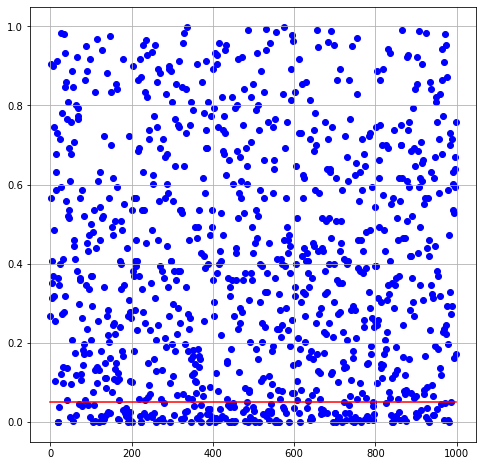

In [ ]:
range1=10000
ones = np.ones((1000,), dtype=int)
p_values = list()

#P-valores para Itamaraca con KS
for i in ones:
  x = np.random.randint(range1, size=1)[0]
  y = np.random.randint(range1, size=1)[0]
  z = np.random.randint(range1, size=1)[0]
  Itamaraca_ = Itamaraca(x,y,z, 10000, 2.1)
  p_values.append(stats.kstest(Itamaraca_.uniformSequence(2000*i), "uniform", args=(0,1))[1])

points = np.arange(0,1000,1)
plt.figure(figsize=(8,8))
plt.scatter(points,np.array(p_values), color="b", marker="o")
plt.plot(points, [0.05 for point in points], color="r")
plt.grid()
plt.show()

Aceptadas: 0.827, Rechazadas: 0.173


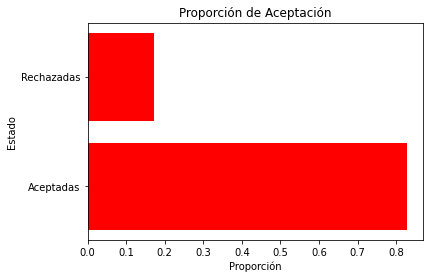

In [ ]:
frec = prop(p_values,0.05)
print(f"Aceptadas: {frec[0]}, Rechazadas: {frec[1]}")
eje_x = ['Aceptadas', 'Rechazadas']
eje_y = list(frec)
 
plt.barh(eje_x, eje_y, color="red")
plt.ylabel('Estado')
plt.xlabel('Proporción')
plt.title('Proporción de Aceptación')
plt.show()

### Xorshift

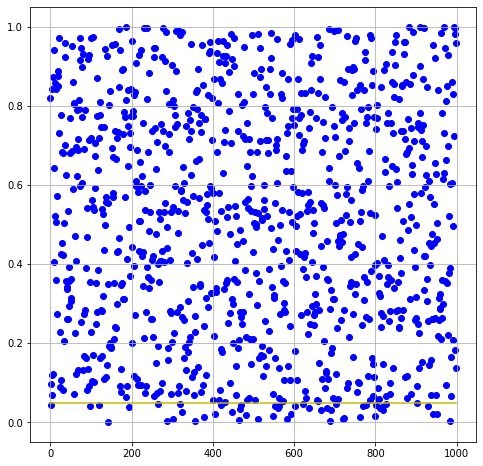

In [ ]:
range1=10000
ones = np.ones((1000,), dtype=int)
p_values = list() 
for i in ones:
  p_values.append(stats.kstest(Scale(Xorshift(np.random.randint(range1),2000*i)), "uniform", args=(0,1))[1])

points = np.arange(0,1000,1)
plt.figure(figsize=(8,8))
plt.scatter(points,np.array(p_values), color="b", marker="o")
plt.plot(points, [0.05 for point in points], color="y")
plt.grid()
plt.show()

Aceptadas: 0.95, Rechazadas: 0.05


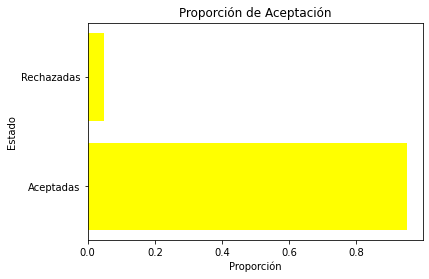

In [ ]:
frec = prop(p_values,0.05)
print(f"Aceptadas: {frec[0]}, Rechazadas: {frec[1]}")
eje_x = ['Aceptadas', 'Rechazadas']
eje_y = list(frec)
 
plt.barh(eje_x, eje_y, color="yellow")
plt.ylabel('Estado')
plt.xlabel('Proporción')
plt.title('Proporción de Aceptación')
plt.show()

### Merssene Twister

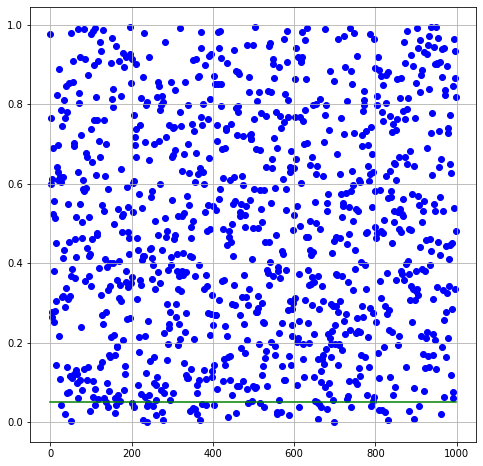

In [ ]:
def generate_random(num):
  n = Random(int(time.time()*1000000))
  random_list = list()
  for i in range (num):
    random_list.append(n.random())
  return random_list

range1=10000
ones = np.ones((1000,), dtype=int)
p_values = list() 
for i in ones:
  p_values.append(stats.kstest(generate_random(2000*i), "uniform", args=(0,1))[1])


points = np.arange(0,1000,1)
plt.figure(figsize=(8,8))
plt.scatter(points,np.array(p_values), color="b", marker="o")
plt.plot(points, [0.05 for point in points], color="g")
plt.grid()
plt.show()

Aceptadas: 0.948, Rechazadas: 0.052


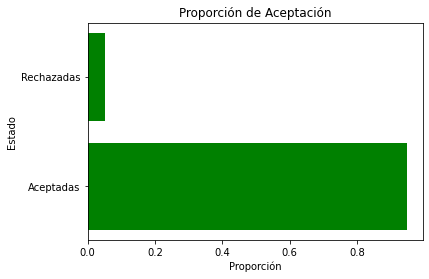

In [ ]:
frec = prop(p_values,0.05)
print(f"Aceptadas: {frec[0]}, Rechazadas: {frec[1]}")
eje_x = ['Aceptadas', 'Rechazadas']
eje_y = list(frec)
 
plt.barh(eje_x, eje_y, color="green")
plt.ylabel('Estado')
plt.xlabel('Proporción')
plt.title('Proporción de Aceptación')
plt.show()

En el grafico es posible observar aquellas muestras las cuales no superarón satisfactoriamente el test. Estas son las que se encuentran por debajo del umbral rojo $0.05$, valor crítico para el cual hay evidencia suficiente para rechazar la hipotesis nula, en este caso, que se distribuye $U(0,1)$. No obstante, es evidente los buenos resultados que este nos ofrece, pues se ve claramente que la cantidad de muestras se superan el test es bastante alta.   

**Nota:** Los aspectos mátemáticos del método son abordados en el articulo adjunto.

## Test de la $\chi^2$

A continuación se presenta implementación del test $\chi^2$ para la simulación. 


### Ita

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


[]

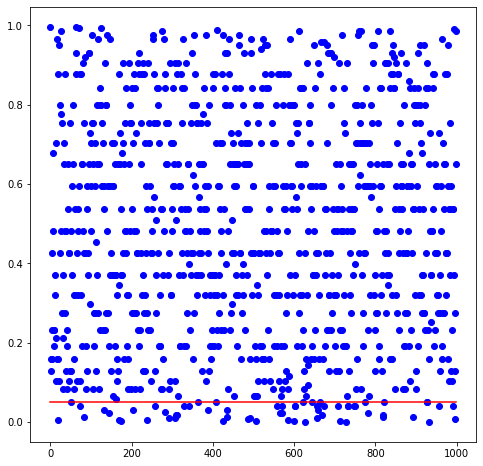

In [ ]:
def Sortfrec2(vector_al):
  arr = np.array(vector_al)
  frec=np.zeros(100)
  for i in range(len(arr)):
    if (arr[i] != np.max(arr) and arr[i]!= np.NaN and arr[i]<1):
      x=vector_al[i]
      x*=100
      x=np.int(np.floor(x))
      frec[x]+=1
  return frec

p_values = list() 
for i in range(1000):
  x = np.random.randint(range1, size=1)[0]
  y = np.random.randint(range1, size=1)[0]
  z = np.random.randint(range1, size=1)[0]
  Itamaraca_ = Itamaraca(x,y,z, 10000, 2.1)
  x = Sortfrec2(Itamaraca_.uniformSequence(100))
  p_values.append(stats.chisquare(x,(len(x)/100)*np.ones(100))[1])


points = np.arange(0,1000,1)
plt.figure(figsize=(8,8))
plt.scatter(points,np.array(p_values), color="b", marker="o")
plt.plot(points, [0.05 for point in points], color="r")
plt.plot()

Aceptadas: 0.947, Rechazadas: 0.053


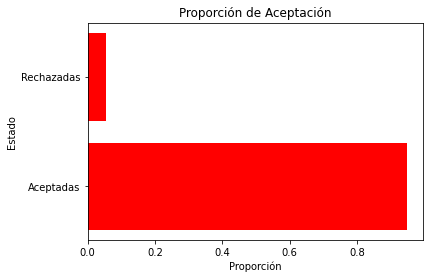

In [ ]:
frec = prop(p_values,0.05)
print(f"Aceptadas: {frec[0]}, Rechazadas: {frec[1]}")
eje_x = ['Aceptadas', 'Rechazadas']
eje_y = list(frec)
 
plt.barh(eje_x, eje_y, color="red")
plt.ylabel('Estado')
plt.xlabel('Proporción')
plt.title('Proporción de Aceptación')
plt.show()

### Xorshift

[]

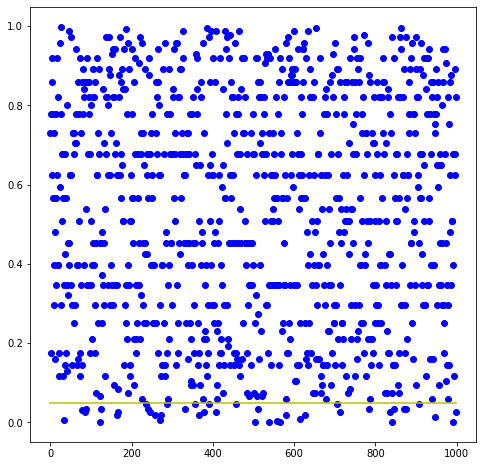

In [ ]:
def Sortfrec3(vector_al):
  arr = np.array(vector_al)
  frec=np.zeros(100)
  for i in range(len(arr)):
    if (arr[i] != np.max(arr) and arr[i]>0):
      x=vector_al[i]
      x*=100
      x=np.int32(np.floor(x))
      frec[x]+=1
  return frec

p_values = list() 
for i in range(1000):
  x = Sortfrec3(Scale(Xorshift(np.random.randint(1000),100)))
  p_values.append(stats.chisquare(x,(len(x)/100)*np.ones(100))[1])


points = np.arange(0,1000,1)
plt.figure(figsize=(8,8))
plt.scatter(points,np.array(p_values), color="b", marker="o")
plt.plot(points, [0.05 for point in points], color="y")
plt.plot()

Aceptadas: 0.958, Rechazadas: 0.042


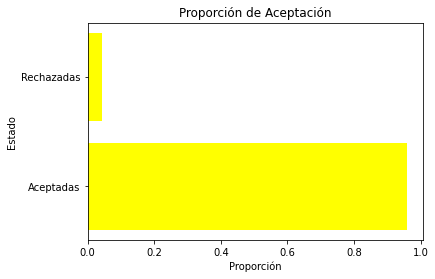

In [ ]:
frec = prop(p_values,0.05)
print(f"Aceptadas: {frec[0]}, Rechazadas: {frec[1]}")
eje_x = ['Aceptadas', 'Rechazadas']
eje_y = list(frec)
 
plt.barh(eje_x, eje_y, color="yellow")
plt.ylabel('Estado')
plt.xlabel('Proporción')
plt.title('Proporción de Aceptación')
plt.show()

### Merssenne Twister. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


[]

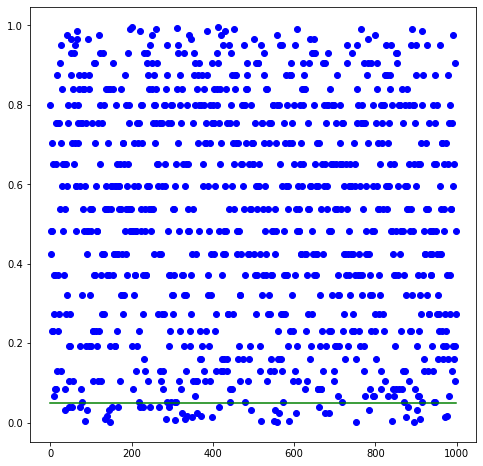

In [ ]:
#toma numeros de [0,1) y los reparte
def generate_random():
  n = Random(int(time.time()*1000000))
  random_list = list()
  for i in range (100):
    random_list.append(n.random())
  return random_list

def Sortfrec(vector_al):
  arr = np.array(vector_al)
  frec=np.zeros(100)
  for i in range(len(arr)):
    if (arr[i] != np.max(arr) and arr[i]!= np.NaN):
      x=vector_al[i]
      x*=100
      x=np.int(np.floor(x))
      frec[x]+=1
  return frec

#ones = np.ones((1000,), dtype=int)

p_values = list() 
for i in range(1000):
  x = Sortfrec(generate_random())
  p_values.append(stats.chisquare(x,(len(x)/100)*np.ones(100))[1])


points = np.arange(0,1000,1)
plt.figure(figsize=(8,8))
plt.scatter(points,np.array(p_values), color="b", marker="o")
plt.plot(points, [0.05 for point in points], color="g")
plt.plot()

Aceptadas: 0.952, Rechazadas: 0.048


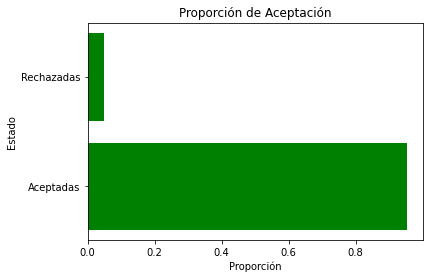

In [ ]:
frec = prop(p_values,0.05)
print(f"Aceptadas: {frec[0]}, Rechazadas: {frec[1]}")
eje_x = ['Aceptadas', 'Rechazadas']
eje_y = list(frec)
 
plt.barh(eje_x, eje_y, color="green")
plt.ylabel('Estado')
plt.xlabel('Proporción')
plt.title('Proporción de Aceptación')
plt.show()

## Binary Matrix Rank Test

Otro metódo de evaluación se basa en detectar relaciones lineales, este se llama *Binary Matrix Rank Test*, este se basa en formar matrices con los números generados y mirar el rango de las mismas, pues una secuencia de números aleatorios no debe producir consistentemente matrices de rango máximo, aqui la implementación del método de evaluación.

*Cabe aclarar que para este test, para usar matrices de $32\times32$ se necesita evaluar una cadena de almenos $32\cdot32\cdot38=38912$ bits, por tanto efectuamos el test con $1216$ números (se puede hacer con más, este solo es un mínimo)*.

In [ ]:
#Código de Binary Matrix Rank Test

#Función diseñada y calibrada para ser usada por la matriz
def Chi_a(A,B,C,N):
   p1, p2, p3=(0.2888, 0.5776,0.1336)
   X=((A-p1*N)**2/(p1*N))+((B-p2*N)**2/(p2*N))+((C-p3*N)**2/(p3*N))
   return X


#Transforma un vector aleatorio de almenos 1216 entradas en una sucesión de matrices
def VectorAMatrices(vector_al,N):
  A = []
  for i in range(N):
    B = np.zeros((32,32))
    for j in range(0,32):
      f=vector_al[32*i+j]
      for k in range(0,32):
          B[j][k]='{:032b}'.format(f)[k]
    A.append(B)
  return A
      
#Calcula los rangos de las matrices de A, y hace la evaluación necesaria
def BinaryRank(vector_al):
   N = math.floor(len(vector_al)/(32))
   matAl=VectorAMatrices(vector_al,N)
   #Estas son las variables importantes en el método
   F_m,F_m1,R=(0,0,0)
   for i in range(N):
     ranAl=np.linalg.matrix_rank(matAl[i])
     if ranAl==32:
       F_m+=1
     elif ranAl==31:
       F_m1+=1
     else:
       R+=1
   X=Chi_a(F_m,F_m1,R,N)
   Pvalor=np.exp(-(X)/2)
   return Pvalor


Ahora aplicamos este criterio a los métodos de generación de arriba

### Xorshift

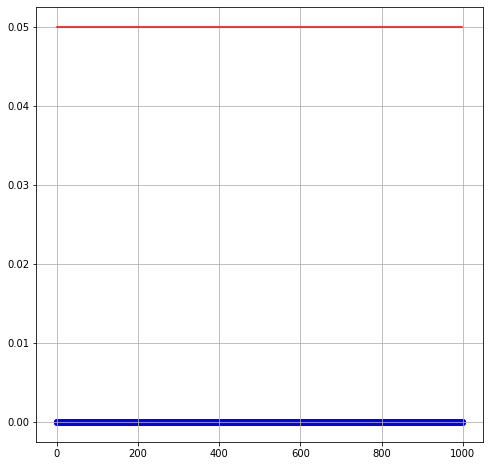

In [ ]:
#Código que evalua el método Xorshift con Binary
range1=10000
ones = np.ones((1000,), dtype=int)
p_values = list() 
for i in ones:
  p_values.append(BinaryRank(Xorshift(np.random.randint(range1),2000*i)))

points = np.arange(0,1000,1)
plt.figure(figsize=(8,8))
plt.scatter(points,np.array(p_values), color="b", marker="o")
plt.plot(points, [0.05 for point in points], color="r")
plt.grid()
plt.show()

Aceptadas: 0.0, Rechazadas: 1.0


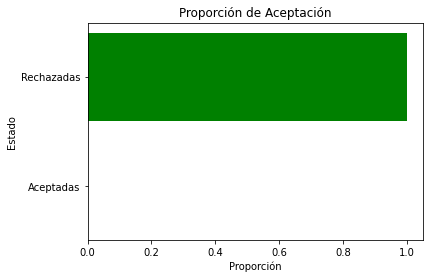

In [ ]:
frec = prop(p_values,0.01)
print(f"Aceptadas: {frec[0]}, Rechazadas: {frec[1]}")
eje_x = ['Aceptadas', 'Rechazadas']
eje_y = list(frec)
 
plt.barh(eje_x, eje_y, color="green")
plt.ylabel('Estado')
plt.xlabel('Proporción')
plt.title('Proporción de Aceptación')
plt.show()